# Imports

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from scipy.stats import entropy

## Fixing Target values

In [2]:
# Combine features and target into a single DataFrame
df = pd.read_csv('data.csv', delimiter=';')

# Encode target variable
mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
df['Target_encoded'] = df['Target'].map(mapping)

In [3]:
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Target_encoded
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,0


## Train-test spliting for original dataset

In [4]:
# Drop the original target column
df = df.drop('Target', axis=1)

# Split the data into features and target
X = df.drop(columns=['Target_encoded'])
y = df['Target_encoded']

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=17)

# Basic and Advanced params for models

In [5]:
# Define common parameters for models
common_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 200
}

In [6]:

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'verbose': 0
}

# XGBoost-specific parameters
xgboost_params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Random Forest-specific parameters
randomforest_params = {
    'n_estimators': 500,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}

# Models with basic params and advanced ones

In [7]:
# Define models
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=17),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=17),
    'RandomForest': RandomForestClassifier(random_state=17)
}

In [8]:
better_models = {
    'CatBoost': CatBoostClassifier(random_state=17, **catboost_params),
    'XGBoost': XGBClassifier(random_state=17, **xgboost_params),
    'RandomForest': RandomForestClassifier(random_state=17, **randomforest_params)
}

# Evaluating model function

In [9]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }

In [10]:
# Evaluate models on full dataset
results_full = {}
for model_name, model in models.items():
    print(f"Training {model_name} on full dataset...")
    results_full[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on full dataset...


# Plotting results for Original Dataset
## *Basic params*

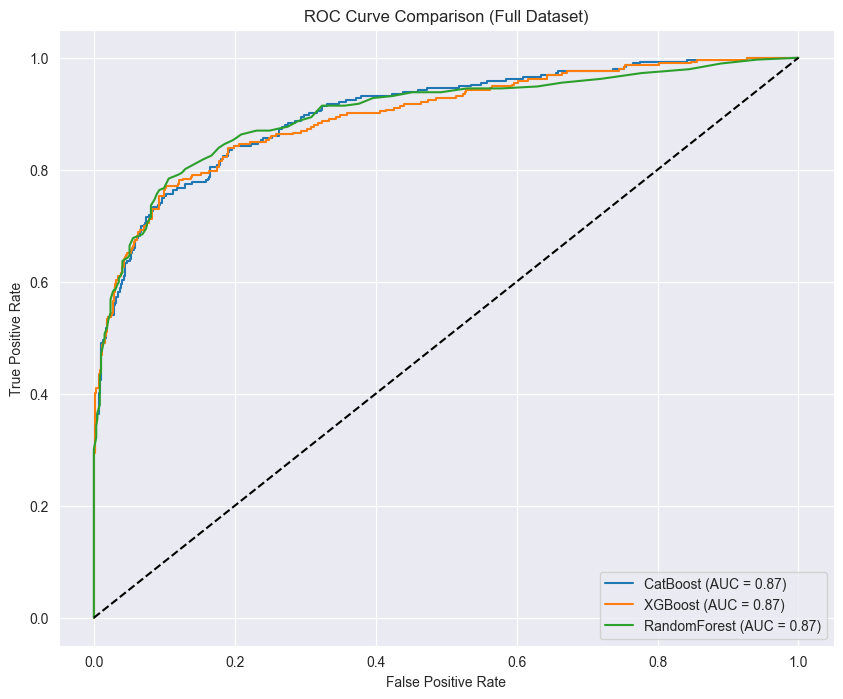

In [11]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_full.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset)')
plt.legend(loc='lower right')
plt.show()

In [12]:
results_full_better = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on full dataset...")
    results_full_better[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on full dataset...


## *Advanced params*

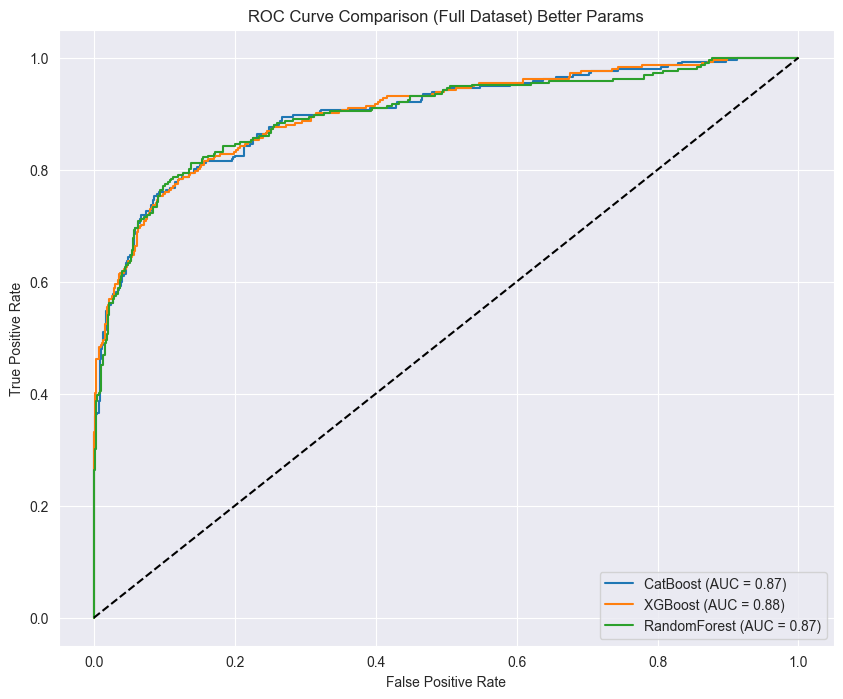

In [13]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for better_model_name, better_result in results_full_better.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset) Better Params')
plt.legend(loc='lower right')
plt.show()

In [14]:
# Print results for full dataset
for model_name, result in results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


In [15]:
for better_model_name, better_result in results_full_better.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8775

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702


# Making sliced dataset

In [16]:
# Slice the dataset
df_sliced = df.sample(frac=0.1, random_state=17)
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

In [17]:
# Split the sliced data into training and testing sets
X_train_sliced, X_test_sliced, y_train_sliced, y_test_sliced = train_test_split(X_sliced, y_sliced, test_size=0.2, random_state=17)

In [18]:
# Evaluate models on sliced dataset
results_sliced = {}
for model_name, model in models.items():
    print(f"Training {model_name} on sliced dataset...")
    results_sliced[model_name] = evaluate_model(model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on sliced dataset...


In [19]:
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on sliced dataset...


# *Slicecd Dataset*
## *Basic params*

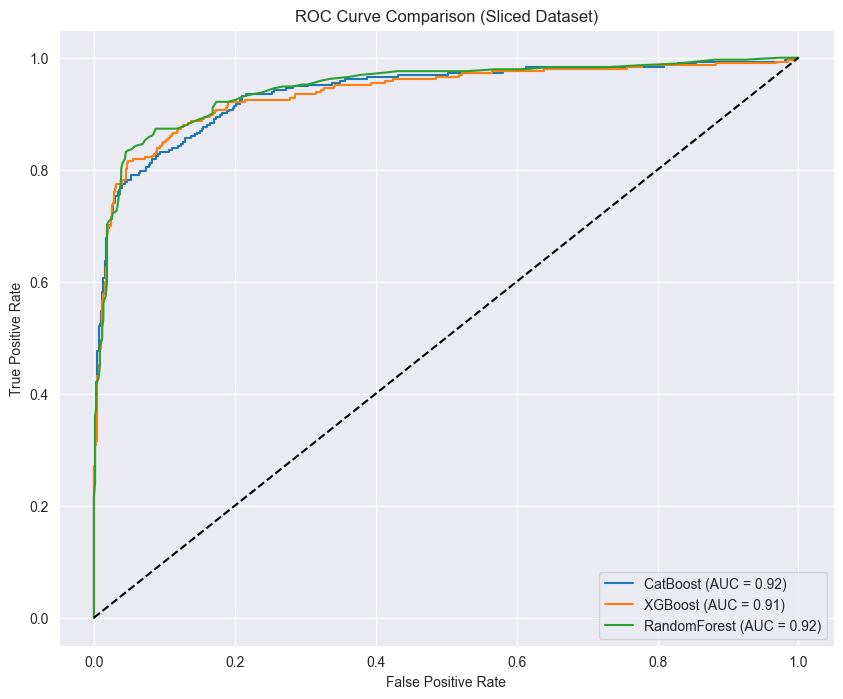

In [20]:
# Plot ROC curves for sliced dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset)')
plt.legend(loc='lower right')
plt.show()

## *Advanced params*

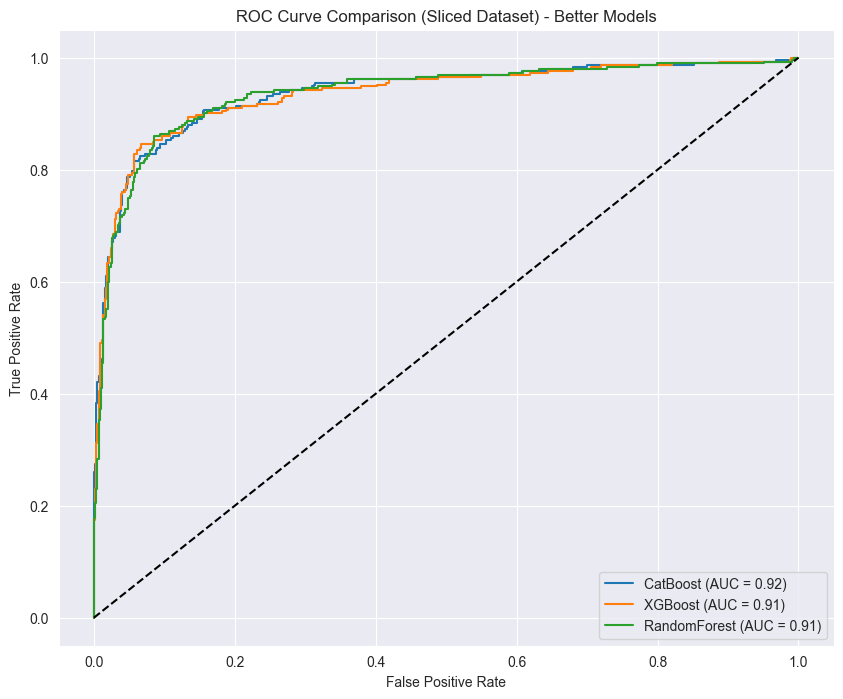

In [21]:
plt.figure(figsize=(10, 8))
for better_model_name, better_result in better_results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset) - Better Models')
plt.legend(loc='lower right')
plt.show()

In [22]:
# Print results for sliced dataset
for model_name, result in results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8192
Precision: 0.8154
Recall: 0.8192
F1-Score: 0.8117
ROC-AUC: 0.9206

Model: XGBoost
Accuracy: 0.8249
Precision: 0.8195
Recall: 0.8249
F1-Score: 0.8204
ROC-AUC: 0.9149

Model: RandomForest
Accuracy: 0.8328
Precision: 0.8295
Recall: 0.8328
F1-Score: 0.8237
ROC-AUC: 0.9248


In [23]:
# Print results for sliced dataset
for better_model_name, better_result in better_results_sliced.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8260
Precision: 0.8212
Recall: 0.8260
F1-Score: 0.8183
ROC-AUC: 0.9104

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131


# Saving sliced dataset

In [24]:
# Save the sliced dataset to a CSV file
df_sliced.to_csv('D:/LLM_exp/df_sliced.csv', index=False)

# Chat-GPT generated dataset

In [25]:
# Load the synthetic dataset generated by GPT
df_gpt = pd.read_csv('D:/LLM_exp/synthetic_dataset.csv')

In [26]:
# Evaluate models on GPT-generated dataset
results_gpt = {}
for model_name, model in models.items():
    print(f"Training {model_name} on GPT-generated dataset...")
    results_gpt[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on GPT-generated dataset...
Training XGBoost on GPT-generated dataset...
Training RandomForest on GPT-generated dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# *GPT-dataset basic params*

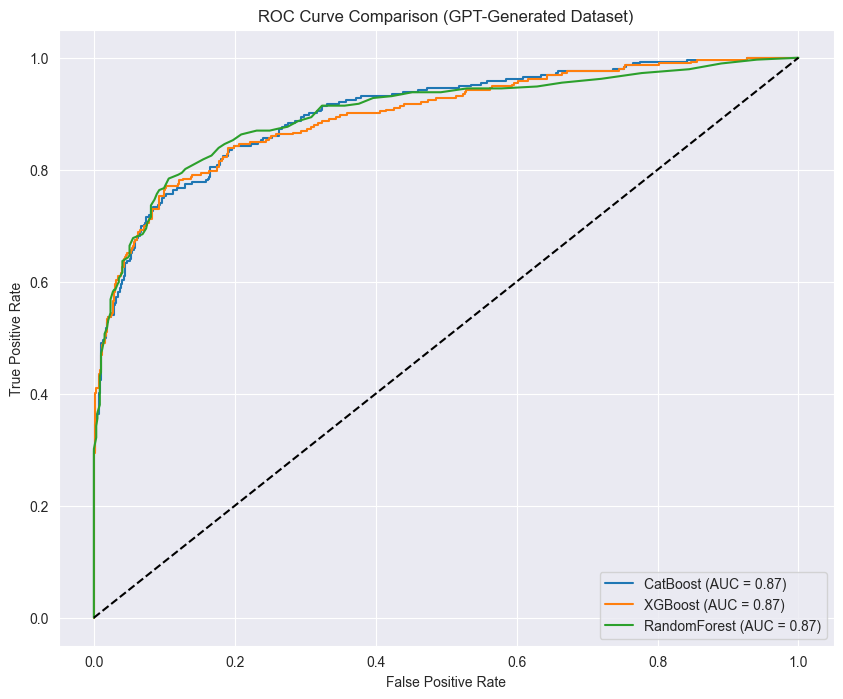

In [27]:
# Plot ROC curves for GPT-generated dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_gpt.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (GPT-Generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Print results for GPT-generated dataset
for model_name, result in results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


## *Deepseek function for generation samples*

In [29]:
# Function to generate a new dataset using resampling (Deepseek)
def generate_new_dataset(original_df, multiplier=10):
    new_data = []
    for _ in range(multiplier):
        resampled_df = resample(original_df, replace=True, n_samples=len(original_df), random_state=np.random.randint(0, 100))
        new_data.append(resampled_df)
    return pd.concat(new_data, ignore_index=True)

## *Copilot function for generation samples (with the second prompt)*

In [30]:
# Function to generate synthetic data (Copilot)
def generate_synthetic_data(data, size_multiplier=10):
    synthetic_data = pd.DataFrame()
    for col in data.columns:
        if col == "Target_encoded":
            synthetic_data[col] = np.random.choice([0, 1, 2], len(data) * size_multiplier)
        elif data[col].dtype in [np.float64, np.int64]:
            synthetic_data[col] = np.random.normal(data[col].mean(), data[col].std(), len(data) * size_multiplier)
        else:
            synthetic_data[col] = np.random.choice(data[col], len(data) * size_multiplier)
    return synthetic_data


In [31]:
# Load the sliced dataset
df_sliced = pd.read_csv('df_sliced.csv')

# Generate deepseek dataset using resampling
df_deepseek = generate_new_dataset(df_sliced, multiplier=10)

# Generate copilot dataset using synthetic data generation
df_copilot = generate_synthetic_data(df_sliced)

## *Dataset preparation*

In [32]:

# Prepare datasets for training and testing
def prepare_datasets(df):
    X = df.drop('Target_encoded', axis=1)
    y = df['Target_encoded']
    return train_test_split(X, y, test_size=0.2, random_state=17)


In [33]:
X_train_deepseek, X_test_deepseek, y_train_deepseek, y_test_deepseek = prepare_datasets(df_deepseek)
X_train_copilot, X_test_copilot, y_train_copilot, y_test_copilot = prepare_datasets(df_copilot)

In [34]:
# Evaluate models on deepseek dataset
results_deepseek = {}
for model_name, model in models.items():
    print(f"Training {model_name} on deepseek dataset...")
    results_deepseek[model_name] = evaluate_model(model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

Training CatBoost on deepseek dataset...
Training XGBoost on deepseek dataset...
Training RandomForest on deepseek dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [35]:
# Evaluate models on copilot dataset
results_copilot = {}
for model_name, model in models.items():
    print(f"Training {model_name} on copilot dataset...")
    results_copilot[model_name] = evaluate_model(model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost on copilot dataset...
Training XGBoost on copilot dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on copilot dataset...


# Deepseek result with basic params

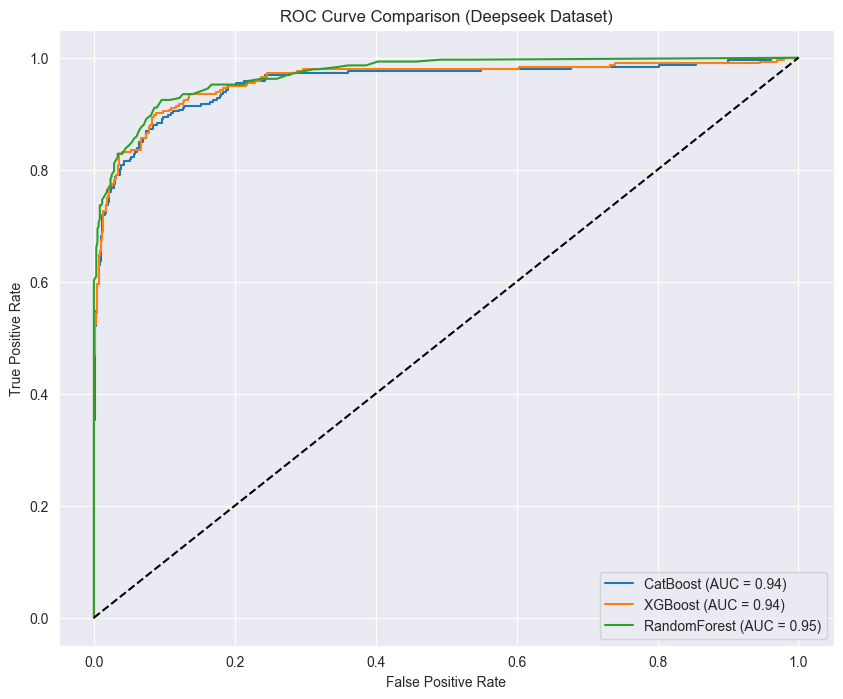

In [36]:
# Plot ROC curves for deepseek dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_deepseek.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Deepseek Dataset)')
plt.legend(loc='lower right')
plt.show()


# Copilot with basic params

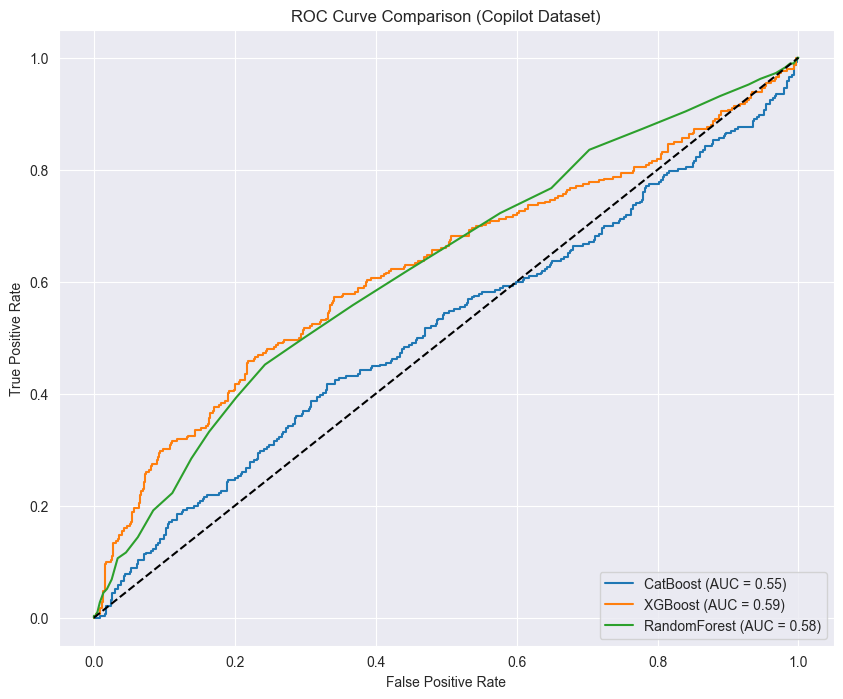

In [37]:
# Plot ROC curves for copilot dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_copilot.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Copilot Dataset)')
plt.legend(loc='lower right')
plt.show()

In [38]:
# Print results for deepseek dataset
print("\nResults for Deepseek Dataset:")
for model_name, result in results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Deepseek Dataset:

Model: CatBoost
Accuracy: 0.8565
Precision: 0.8537
Recall: 0.8565
F1-Score: 0.8516
ROC-AUC: 0.9394

Model: XGBoost
Accuracy: 0.8554
Precision: 0.8516
Recall: 0.8554
F1-Score: 0.8525
ROC-AUC: 0.9409

Model: RandomForest
Accuracy: 0.8655
Precision: 0.8626
Recall: 0.8655
F1-Score: 0.8592
ROC-AUC: 0.9546


In [39]:
# Print results for copilot dataset
print("\nResults for Copilot Dataset:")
for model_name, result in results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Copilot Dataset:

Model: CatBoost
Accuracy: 0.4599
Precision: 0.4382
Recall: 0.4599
F1-Score: 0.4471
ROC-AUC: 0.5465

Model: XGBoost
Accuracy: 0.4847
Precision: 0.4798
Recall: 0.4847
F1-Score: 0.4721
ROC-AUC: 0.5934

Model: RandomForest
Accuracy: 0.4802
Precision: 0.4685
Recall: 0.4802
F1-Score: 0.4717
ROC-AUC: 0.5821


In [40]:
# Evaluate better models on full dataset
better_results_full = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on full dataset...")
    better_results_full[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on sliced dataset
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

# Evaluate better models on GPT-generated dataset
better_results_gpt = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on GPT-generated dataset...")
    better_results_gpt[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on deepseek dataset
better_results_deepseek = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on deepseek dataset...")
    better_results_deepseek[better_model_name] = evaluate_model(better_model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

# Evaluate better models on copilot dataset
better_results_copilot = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on copilot dataset...")
    better_results_copilot[better_model_name] = evaluate_model(better_model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost with better parameters on full dataset...
Training XGBoost with better parameters on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest with better parameters on full dataset...
Training CatBoost with better parameters on sliced dataset...
Training XGBoost with better parameters on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest with better parameters on sliced dataset...
Training CatBoost with better parameters on GPT-generated dataset...
Training XGBoost with better parameters on GPT-generated dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest with better parameters on GPT-generated dataset...
Training CatBoost with better parameters on deepseek dataset...
Training XGBoost with better parameters on deepseek dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest with better parameters on deepseek dataset...
Training CatBoost with better parameters on copilot dataset...
Training XGBoost with better parameters on copilot dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest with better parameters on copilot dataset...


# All models plotting results

              Dataset         Model  Accuracy  Precision    Recall  F1-Score  \
0            Original      CatBoost  0.750282   0.741858  0.750282  0.744126   
1            Original       XGBoost  0.746893   0.740024  0.746893  0.740659   
2            Original  RandomForest  0.772881   0.765165  0.772881  0.763118   
3              Sliced      CatBoost  0.819209   0.815402  0.819209  0.811709   
4              Sliced       XGBoost  0.824859   0.819459  0.824859  0.820431   
5              Sliced  RandomForest  0.832768   0.829466  0.832768  0.823747   
6                 GPT      CatBoost  0.750282   0.741858  0.750282  0.744126   
7                 GPT       XGBoost  0.746893   0.740024  0.746893  0.740659   
8                 GPT  RandomForest  0.772881   0.765165  0.772881  0.763118   
9            Deepseek      CatBoost  0.856497   0.853733  0.856497  0.851563   
10           Deepseek       XGBoost  0.855367   0.851633  0.855367  0.852517   
11           Deepseek  RandomForest  0.8

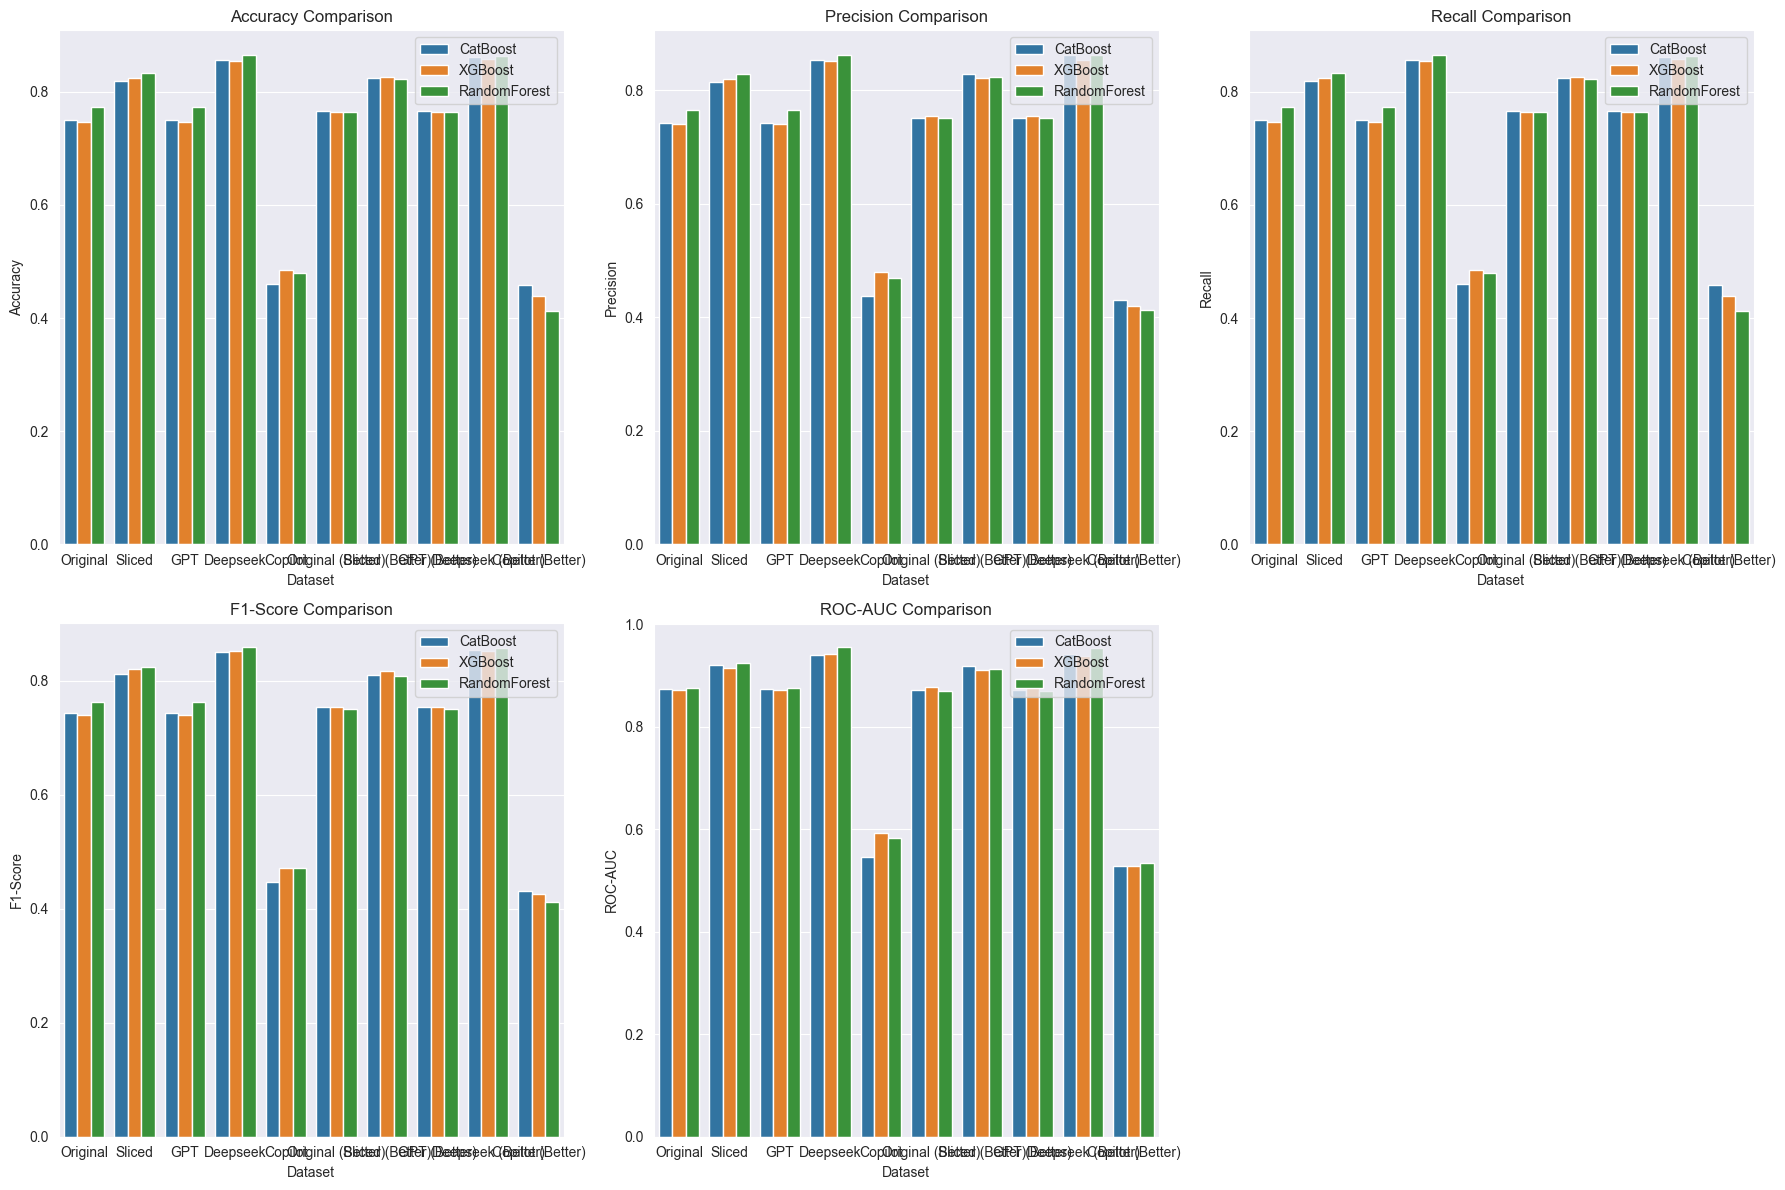

In [41]:
results = {
    'Dataset': [],
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}


for model_name, result in results_full.items():
    results['Dataset'].append('Original')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_sliced.items():
    results['Dataset'].append('Sliced')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_gpt.items():
    results['Dataset'].append('GPT')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_deepseek.items():
    results['Dataset'].append('Deepseek')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_copilot.items():
    results['Dataset'].append('Copilot')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in better_results_full.items():
    results['Dataset'].append('Original (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_sliced.items():
    results['Dataset'].append('Sliced (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_gpt.items():
    results['Dataset'].append('GPT (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_deepseek.items():
    results['Dataset'].append('Deepseek (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_copilot.items():
    results['Dataset'].append('Copilot (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


results_df = pd.DataFrame(results)


print(results_df)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Plotting basic params models

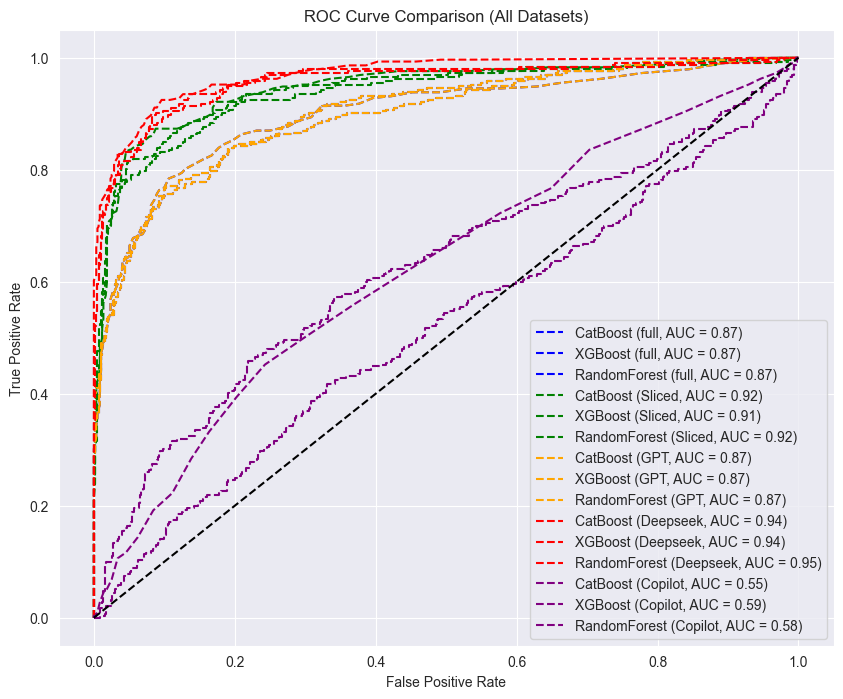

In [42]:
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced','GPT','Deepseek', 'Copilot'], ['blue', 'green', 'orange','red', 'purple','yellow']):
    for model_name, result in eval(f'results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets)')
plt.legend(loc='lower right')
plt.show()

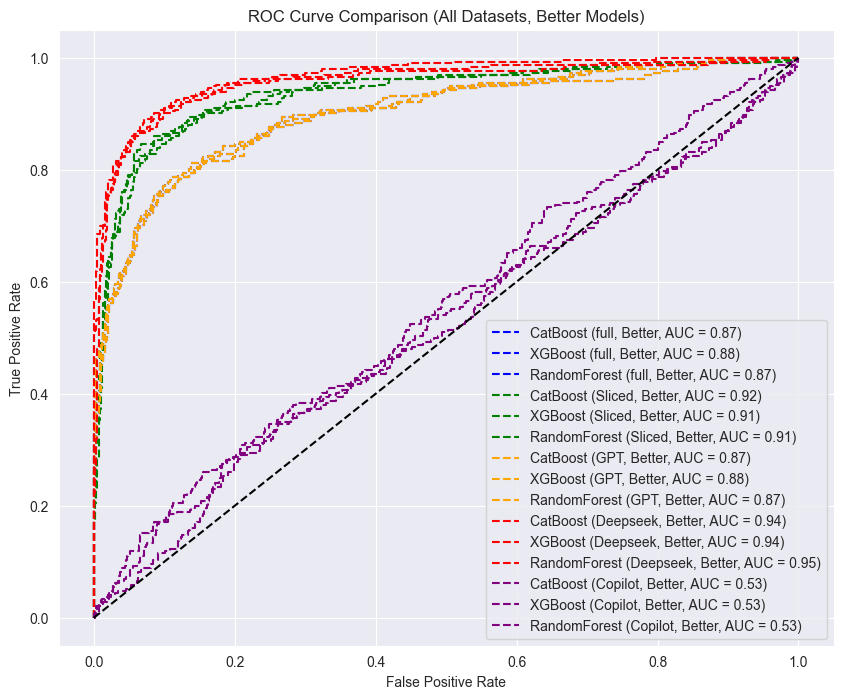

In [43]:
# Plot updated ROC curves
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced', 'GPT', 'Deepseek', 'Copilot'], ['blue', 'green', 'orange', 'red', 'purple', 'yellow']):
    for model_name, result in eval(f'better_results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, Better, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets, Better Models)')
plt.legend(loc='lower right')
plt.show()

## Result for better params for all datasets

In [44]:
# Print results for better models on full dataset
print("\nResults for Better Models on Full Dataset:")
for model_name, result in better_results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on sliced dataset
print("\nResults for Better Models on Sliced Dataset:")
for model_name, result in better_results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on GPT-generated dataset
print("\nResults for Better Models on GPT-Generated Dataset:")
for model_name, result in better_results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on deepseek dataset
print("\nResults for Better Models on Deepseek Dataset:")
for model_name, result in better_results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on copilot dataset
print("\nResults for Better Models on Copilot Dataset:")
for model_name, result in better_results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Better Models on Full Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8775

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702

Results for Better Models on Sliced Dataset:

Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8260
Precision: 0.8212
Recall: 0.8260
F1-Score: 0.8183
ROC-AUC: 0.9104

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131

Results for Better Models on GPT-Generated Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8775

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7

In [45]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.680154
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.759359
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


In [46]:
df_sliced.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,...,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,1.167421,18.294118,1.683258,8910.115385,0.909502,4.361991,132.630543,1.859729,17.052036,20.789593,...,0.502262,6.192308,7.830317,4.452489,10.400820,0.128959,11.663348,1.067195,-0.061448,0.671946
std,0.609097,17.262398,1.215598,1992.980304,0.287219,9.945895,12.782673,7.011054,14.976308,15.469774,...,1.738257,2.074931,3.618507,2.897142,5.200203,0.570732,2.570735,1.404313,2.269422,0.739909
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,1.000000,3.000000,...,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,182.000000,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.000000,17.000000,16.666667,5.000000,16.200000,3.700000,3.510000,2.000000


In [47]:
df_copilot.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.176593,17.978700,1.678768,8891.787609,0.911941,4.341557,132.737392,1.750715,16.952486,20.875661,...,0.483347,6.165818,7.779313,4.445674,10.462943,0.126266,11.633004,1.047829,-0.047020,0.992986
std,0.604699,17.384909,1.207647,1987.575002,0.282302,9.963243,12.726760,6.929560,14.829215,15.692101,...,1.730078,2.084954,3.637007,2.875516,5.215465,0.569978,2.618339,1.400332,2.318419,0.824053
min,-0.969803,-44.987251,-2.443935,2366.995812,-0.297740,-35.898307,87.490936,-21.010065,-35.467080,-31.379605,...,-5.604993,-0.931430,-6.854931,-5.130822,-7.449526,-2.073779,2.207567,-4.403462,-8.732059,0.000000
25%,0.777211,6.261680,0.875833,7515.698161,0.717455,-2.331428,124.392332,-2.892448,6.877915,10.332277,...,-0.739895,4.763715,5.304663,2.515504,6.860844,-0.270444,9.905378,0.115392,-1.625472,0.000000
50%,1.170827,18.046145,1.681815,8872.714443,0.916100,4.331785,132.818494,1.700702,17.077179,20.406458,...,0.475157,6.165498,7.796895,4.444540,10.526652,0.133391,11.612024,1.068306,-0.046743,1.000000
75%,1.579737,29.638203,2.491119,10303.743218,1.101254,11.011347,141.209067,6.274756,27.226377,31.369651,...,1.648114,7.506955,10.288588,6.326264,13.890442,0.516753,13.383008,1.972429,1.515533,2.000000
max,3.275303,81.192544,5.868904,16684.733977,1.873295,41.047369,180.563086,27.641322,66.458046,85.700488,...,5.808515,13.180718,20.401003,15.042623,29.499908,2.222511,20.427992,5.847216,8.985455,2.000000


In [48]:
df_gpt = pd.read_csv('D:/LLM_exp/synthetic_dataset.csv')

In [49]:
df_gpt.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.159276,18.476697,1.664706,8887.362443,0.914480,4.460407,132.520360,1.880995,16.869231,20.907692,...,0.488914,6.216063,7.717904,4.505204,10.438599,0.130543,11.707489,1.060271,-0.107265,0.676471
std,0.583369,17.313390,1.201859,2048.238672,0.279686,10.134578,12.792340,6.866776,15.006285,15.362883,...,1.717056,2.053960,3.650836,2.816918,5.235437,0.577875,2.578125,1.417859,2.272290,0.742063
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,86.160710,1.000000,1.000000,1.000000,...,0.000000,0.000000,-6.857544,0.000000,-6.574867,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,124.052609,1.000000,1.000000,3.000000,...,0.000000,5.000000,5.265149,3.000000,6.925985,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,132.486810,1.000000,19.000000,19.000000,...,0.000000,6.000000,7.740342,5.000000,10.401450,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,141.359255,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.210165,6.000000,14.005395,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,180.668433,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.520884,17.000000,28.998620,5.000000,16.200000,3.700000,3.510000,2.000000


In [50]:
df_deepseek.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.178959,18.569683,1.691855,8887.007692,0.904525,4.469683,132.470566,1.909276,17.197964,21.292760,...,0.482579,6.157240,7.736199,4.435068,10.313683,0.118326,11.702986,1.114661,-0.018871,0.650679
std,0.619047,17.156927,1.223803,2039.378038,0.293903,10.066749,12.593980,7.555432,14.962726,15.317129,...,1.695385,2.073863,3.635410,2.904934,5.246876,0.528250,2.576088,1.402517,2.273669,0.732130
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,1.000000,3.000000,...,0.000000,5.000000,6.000000,3.000000,10.842857,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,0.600000,0.320000,0.000000
75%,1.000000,39.000000,2.000000,9584.500000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,182.000000,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.000000,17.000000,16.666667,5.000000,16.200000,3.700000,3.510000,2.000000


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

# KL Divergence test

In [64]:
def calculate_kl_divergence(dataset1, dataset2, bins=50):
    """
    Calculate KL divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise KL divergence values.
    """
    kl_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero by adding a small value (epsilon)
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                kl_divergences[column] = entropy(hist1, hist2)
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return kl_divergences

In [61]:
# Example usage with existing datasets
# Assuming datasets are named df_train and df_synthetic
kl_results_gpt = calculate_kl_divergence(df, df_gpt)


# Display KL divergence results
print("KL Divergence results for GPT (feature-wise):")
for feature, kl_value in kl_results_gpt.items():
    print(f"{feature}: {kl_value:.4f}")


    mean_kl_divergence = np.mean(list(kl_results_gpt.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")




KL Divergence results for GPT (feature-wise):
Application mode: 0.0197
Application order: 0.0151
Course: 0.0094
Previous qualification: 0.0360
Previous qualification (grade): 0.3084
Nacionality: 0.0722
Mother's qualification: 0.1632
Father's qualification: 0.1373
Mother's occupation: 0.1139
Father's occupation: 0.1885
Admission grade: 0.1311
Displaced: 0.0000
Educational special needs: 0.0008
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0021
Scholarship holder: 0.0000
Age at enrollment: 0.9439
International: 0.0008
Curricular units 1st sem (credited): 0.1657
Curricular units 1st sem (enrolled): 0.0974
Curricular units 1st sem (evaluations): 0.4932
Curricular units 1st sem (approved): 0.3137
Curricular units 1st sem (grade): 1.2020
Curricular units 1st sem (without evaluations): 0.0733
Curricular units 2nd sem (credited): 0.1459
Curricular units 2nd sem (enrolled): 0.0541
Curricular units 2nd sem (evaluations): 0.8159
Curricular units 2nd sem (approved): 0.0515
Curricular un

In [62]:
kl_results_deepseek = calculate_kl_divergence(df, df_deepseek)
print("KL Divergence results for Deepseek (feature-wise):")
for feature, kl_value in kl_results_deepseek.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_deepseek.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Deepseek (feature-wise):
Marital status: 0.0407
Application mode: 0.0246
Application order: 0.0173
Course: 0.0057
Daytime/evening attendance	: 0.0010
Previous qualification: 0.0380
Previous qualification (grade): 0.2615
Nacionality: 0.0733
Mother's qualification: 0.1658
Father's qualification: 0.1341
Mother's occupation: 0.1118
Father's occupation: 0.1945
Admission grade: 0.2341
Displaced: 0.0004
Educational special needs: 0.0014
Debtor: 0.0004
Tuition fees up to date: 0.0001
Gender: 0.0025
Scholarship holder: 0.0000
Age at enrollment: 0.2595
International: 0.0001
Curricular units 1st sem (credited): 0.1649
Curricular units 1st sem (enrolled): 0.0916
Curricular units 1st sem (evaluations): 0.1189
Curricular units 1st sem (approved): 0.3153
Curricular units 1st sem (grade): 0.0348
Curricular units 1st sem (without evaluations): 0.0723
Curricular units 2nd sem (credited): 0.1419
Curricular units 2nd sem (enrolled): 0.0539
Curricular units 2nd sem (evaluations): 

In [63]:
kl_results_copilot = calculate_kl_divergence(df, df_copilot)
print("KL Divergence results for Copilot (feature-wise):")
for feature, kl_value in kl_results_copilot.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_copilot.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Copilot (feature-wise):
Marital status: 2.5834
Application mode: 2.1005
Application order: 2.7692
Course: 1.9902
Daytime/evening attendance	: 5.3178
Previous qualification: 2.7471
Previous qualification (grade): 0.2925
Nacionality: 1.6685
Mother's qualification: 2.2234
Father's qualification: 2.2228
Mother's occupation: 1.7876
Father's occupation: 1.6783
Admission grade: 0.1415
Displaced: 3.7822
Educational special needs: 1.8921
Debtor: 3.3094
Tuition fees up to date: 3.3768
Gender: 3.4801
Scholarship holder: 3.5693
Age at enrollment: 0.9577
International: 2.8574
Curricular units 1st sem (credited): 2.2111
Curricular units 1st sem (enrolled): 1.4723
Curricular units 1st sem (evaluations): 0.4912
Curricular units 1st sem (approved): 1.0787
Curricular units 1st sem (grade): 1.2495
Curricular units 1st sem (without evaluations): 1.6383
Curricular units 2nd sem (credited): 2.0442
Curricular units 2nd sem (enrolled): 1.3933
Curricular units 2nd sem (evaluations): 0

# JS Divergence

In [72]:
def calculate_js_divergence(dataset1, dataset2, bins=50):
    """
    Calculate Jensen-Shannon divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise Jensen-Shannon divergence values.
    """
    js_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero by adding a small value (epsilon)
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                # Calculate the midpoint distribution
                midpoint = 0.5 * (hist1 + hist2)

                # Calculate Jensen-Shannon divergence
                js_divergence = 0.5 * (entropy(hist1, midpoint) + entropy(hist2, midpoint))
                js_divergences[column] = js_divergence
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return js_divergences

In [75]:
js_results_gpt = calculate_js_divergence(df, df_gpt)



# Display Distribution Overlap results
print("\nDistribution Overlap results (feature-wise):")
for feature, overlap in js_results_gpt.items():
    print(f"{feature}: {overlap:.4f}")

# Calculate and display the mean Distribution Overlap
mean_overlap = np.mean(list(js_results_gpt.values()))
print(f"\nMean Distribution Overlap: {mean_overlap:.4f}")


Distribution Overlap results (feature-wise):
Application mode: 0.0025
Application order: 0.0019
Course: 0.0023
Previous qualification: 0.0029
Previous qualification (grade): 0.0583
Nacionality: 0.0028
Mother's qualification: 0.0104
Father's qualification: 0.0082
Mother's occupation: 0.0041
Father's occupation: 0.0062
Admission grade: 0.0202
Displaced: 0.0000
Educational special needs: 0.0002
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0005
Scholarship holder: 0.0000
Age at enrollment: 0.1291
International: 0.0002
Curricular units 1st sem (credited): 0.0051
Curricular units 1st sem (enrolled): 0.0045
Curricular units 1st sem (evaluations): 0.1072
Curricular units 1st sem (approved): 0.0095
Curricular units 1st sem (grade): 0.2638
Curricular units 1st sem (without evaluations): 0.0020
Curricular units 2nd sem (credited): 0.0047
Curricular units 2nd sem (enrolled): 0.0026
Curricular units 2nd sem (evaluations): 0.1986
Curricular units 2nd sem (approved): 0.0055
Curricular un

In [76]:
js_results_deepseek = calculate_js_divergence(df, df_deepseek)




# Display Jensen-Shannon divergence results
print("\nJensen-Shannon Divergence results (feature-wise):")
for feature, js_value in js_results_deepseek.items():
    print(f"{feature}: {js_value:.4f}")

# Calculate and display the mean Jensen-Shannon divergence
mean_js_divergence = np.mean(list(js_results_deepseek.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results (feature-wise):
Marital status: 0.0010
Application mode: 0.0037
Application order: 0.0025
Course: 0.0014
Daytime/evening attendance	: 0.0003
Previous qualification: 0.0031
Previous qualification (grade): 0.0131
Nacionality: 0.0030
Mother's qualification: 0.0111
Father's qualification: 0.0074
Mother's occupation: 0.0038
Father's occupation: 0.0076
Admission grade: 0.0145
Displaced: 0.0001
Educational special needs: 0.0003
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0006
Scholarship holder: 0.0000
Age at enrollment: 0.0116
International: 0.0000
Curricular units 1st sem (credited): 0.0049
Curricular units 1st sem (enrolled): 0.0035
Curricular units 1st sem (evaluations): 0.0074
Curricular units 1st sem (approved): 0.0099
Curricular units 1st sem (grade): 0.0057
Curricular units 1st sem (without evaluations): 0.0018
Curricular units 2nd sem (credited): 0.0039
Curricular units 2nd sem (enrolled): 0.0025
Curricular units 2nd sem (evaluations): 

In [77]:
js_results_copilot = calculate_js_divergence(df, df_copilot)




# Display Jensen-Shannon divergence results
print("\nJensen-Shannon Divergence results (feature-wise):")
for feature, js_value in js_results_copilot.items():
    print(f"{feature}: {js_value:.4f}")

# Calculate and display the mean Jensen-Shannon divergence
mean_js_divergence = np.mean(list(js_results_copilot.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results (feature-wise):
Marital status: 0.4923
Application mode: 0.4625
Application order: 0.4896
Course: 0.3638
Daytime/evening attendance	: 0.5997
Previous qualification: 0.5072
Previous qualification (grade): 0.0553
Nacionality: 0.3877
Mother's qualification: 0.4734
Father's qualification: 0.4726
Mother's occupation: 0.3419
Father's occupation: 0.3233
Admission grade: 0.0205
Displaced: 0.6384
Educational special needs: 0.4334
Debtor: 0.6114
Tuition fees up to date: 0.6154
Gender: 0.6239
Scholarship holder: 0.6286
Age at enrollment: 0.1289
International: 0.5338
Curricular units 1st sem (credited): 0.4161
Curricular units 1st sem (enrolled): 0.3104
Curricular units 1st sem (evaluations): 0.1124
Curricular units 1st sem (approved): 0.2545
Curricular units 1st sem (grade): 0.2724
Curricular units 1st sem (without evaluations): 0.3130
Curricular units 2nd sem (credited): 0.3987
Curricular units 2nd sem (enrolled): 0.3239
Curricular units 2nd sem (evaluations): 

KL Divergence results (feature-wise):
Marital status: 0.0407
Application mode: 0.0246
Application order: 0.0173
Course: 0.0057
Daytime/evening attendance	: 0.0010
Previous qualification: 0.0380
Previous qualification (grade): 0.2615
Nacionality: 0.0733
Mother's qualification: 0.1658
Father's qualification: 0.1341
Mother's occupation: 0.1118
Father's occupation: 0.1945
Admission grade: 0.2341
Displaced: 0.0004
Educational special needs: 0.0014
Debtor: 0.0004
Tuition fees up to date: 0.0001
Gender: 0.0025
Scholarship holder: 0.0000
Age at enrollment: 0.2595
International: 0.0001
Curricular units 1st sem (credited): 0.1649
Curricular units 1st sem (enrolled): 0.0916
Curricular units 1st sem (evaluations): 0.1189
Curricular units 1st sem (approved): 0.3153
Curricular units 1st sem (grade): 0.0348
Curricular units 1st sem (without evaluations): 0.0723
Curricular units 2nd sem (credited): 0.1419
Curricular units 2nd sem (enrolled): 0.0539
Curricular units 2nd sem (evaluations): 0.1417
Curric

D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


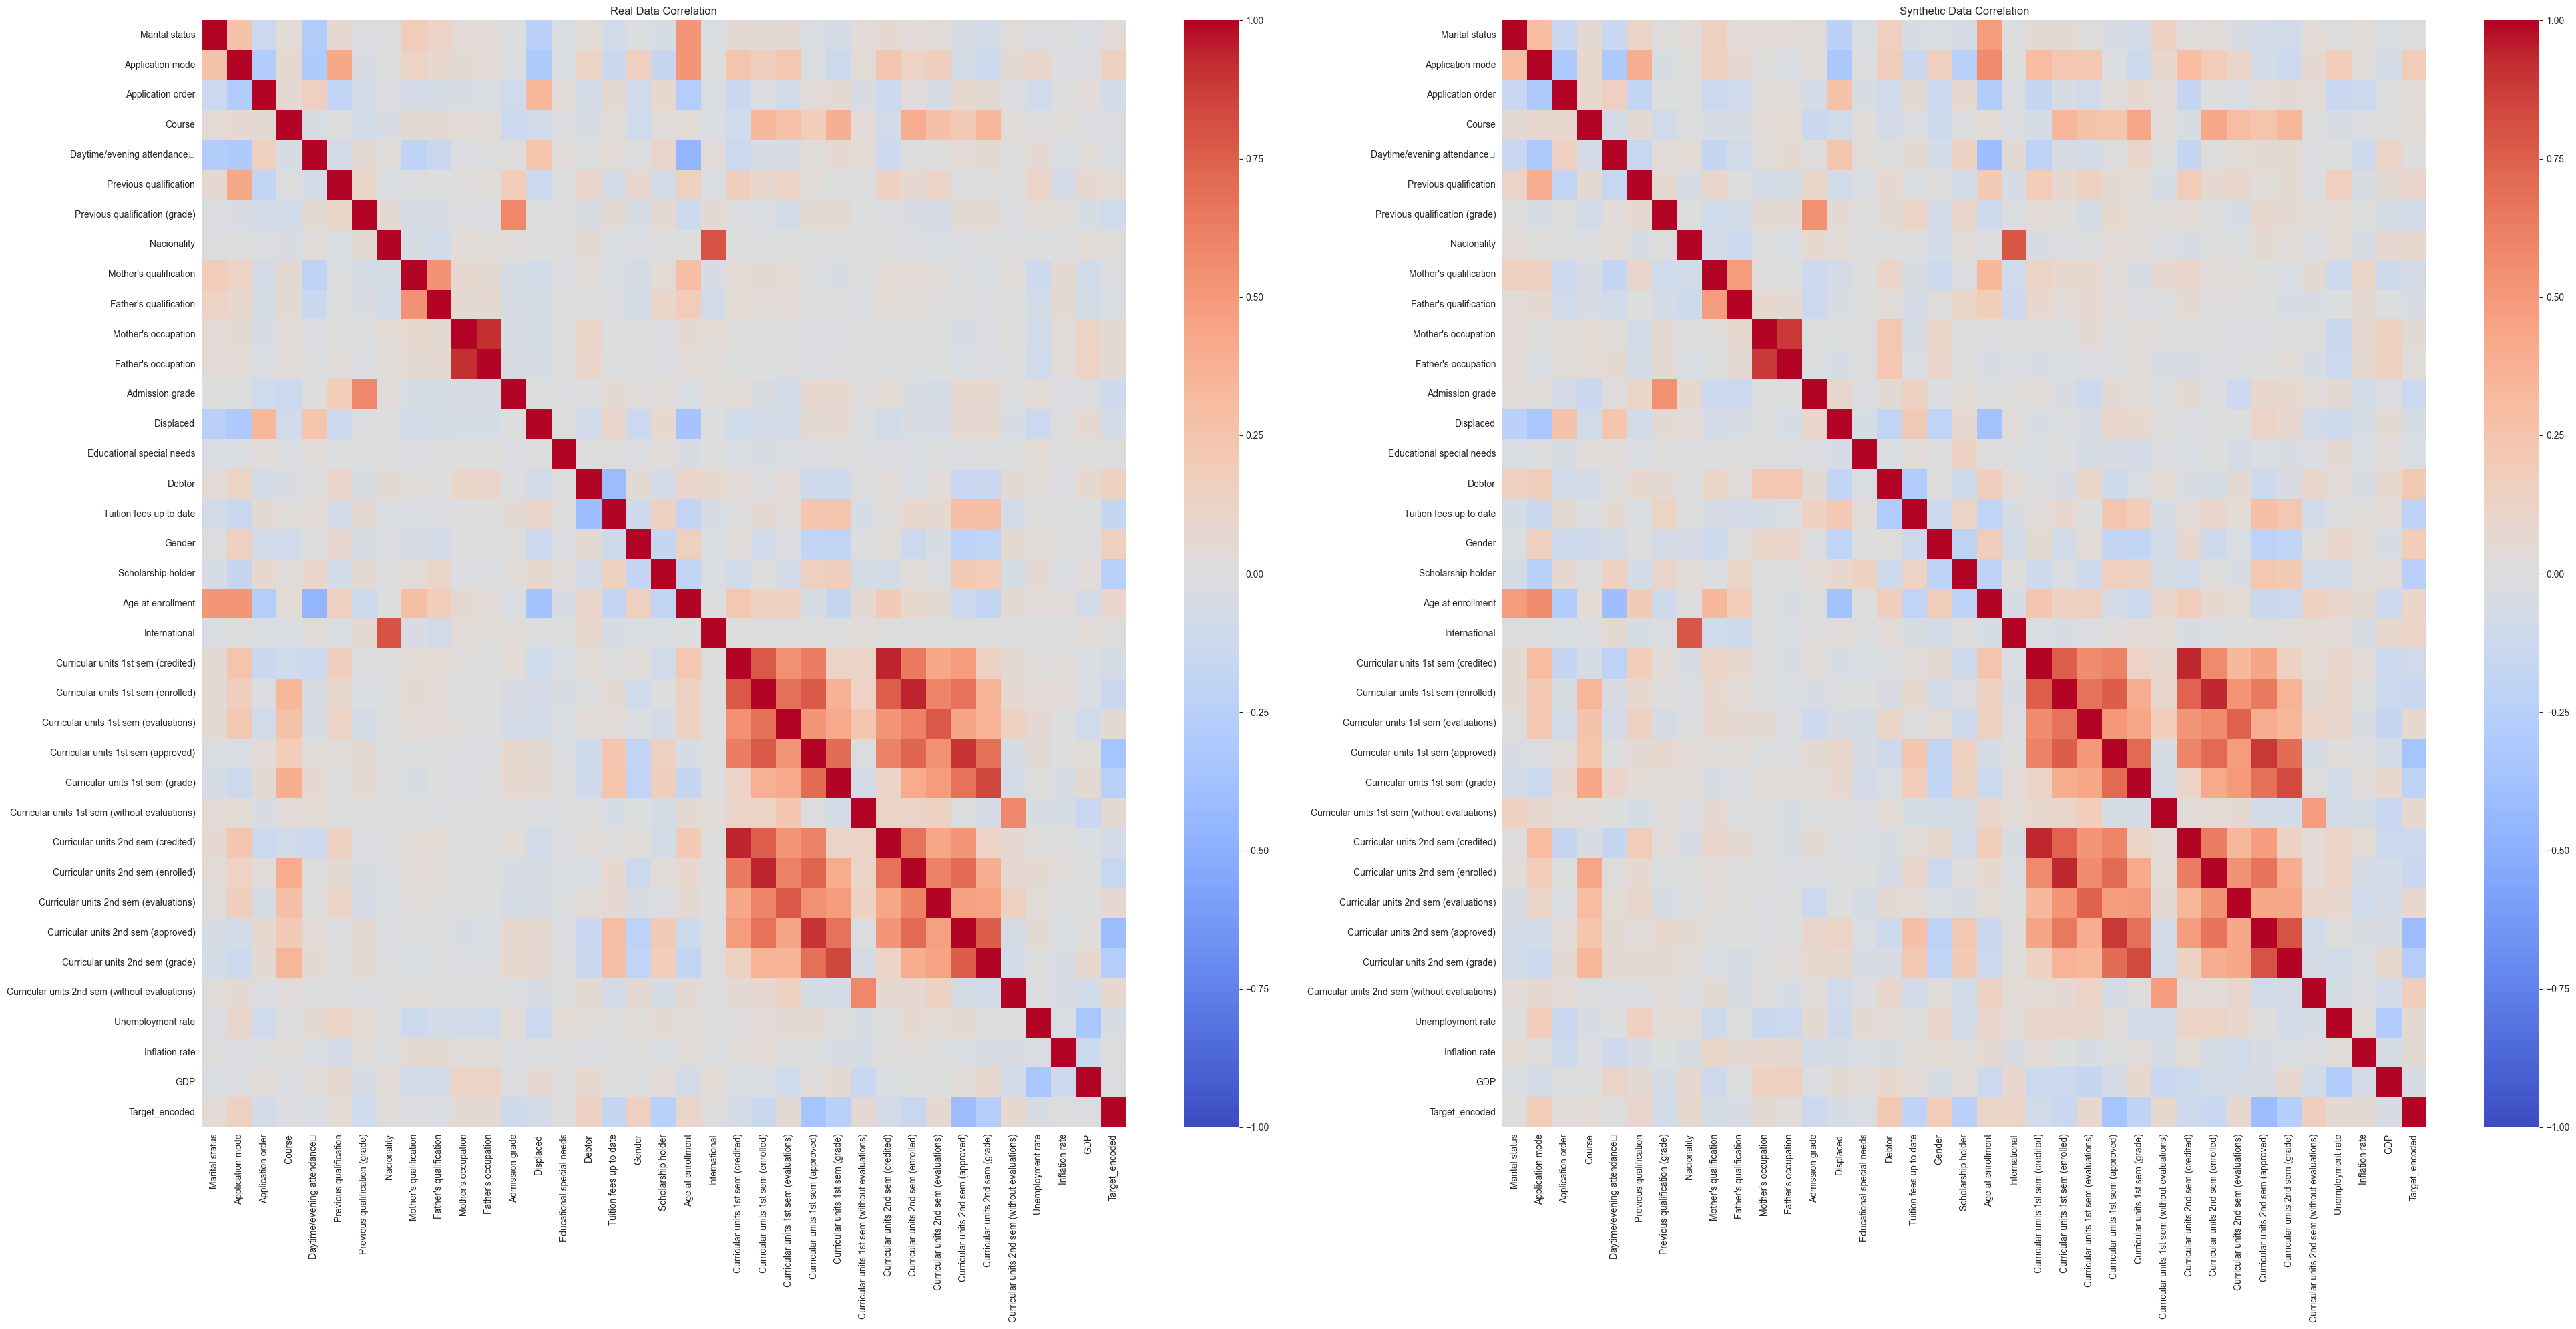

In [86]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance, ks_2samp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Earth Mover's Distance (Wasserstein Distance)
def calculate_wasserstein_distance(dataset1, dataset2):
    """
    Calculate Wasserstein Distance between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise Wasserstein Distance values.
    """
    wasserstein_distances = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                wasserstein_distances[column] = wasserstein_distance(dataset1[column], dataset2[column])
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return wasserstein_distances

# Function to perform Kolmogorov-Smirnov Test
def kolmogorov_smirnov_test(dataset1, dataset2):
    """
    Perform Kolmogorov-Smirnov Test between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise p-values from KS Test.
    """
    ks_results = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                _, p_value = ks_2samp(dataset1[column], dataset2[column])
                ks_results[column] = p_value
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return ks_results

# Function to compare correlation matrices
def compare_correlation_matrices(real_data, synthetic_data):
    """
    Compare correlation matrices for real and synthetic datasets.

    Args:
        real_data (pd.DataFrame): Real dataset.
        synthetic_data (pd.DataFrame): Synthetic dataset.
    """
    real_corr = real_data.corr()
    synthetic_corr = synthetic_data.corr()

    plt.figure(figsize=(40, 20))

    # Real dataset heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Real Data Correlation")

    # Synthetic dataset heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(synthetic_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Synthetic Data Correlation")

    plt.tight_layout()
    plt.show()


kl_results = calculate_kl_divergence(df, df_deepseek)
wasserstein_results = calculate_wasserstein_distance(df, df_deepseek)
ks_results = kolmogorov_smirnov_test(df, df_deepseek)

# Display results
print("KL Divergence results (feature-wise):")
for feature, kl_value in kl_results.items():
    print(f"{feature}: {kl_value:.4f}")

print("\nWasserstein Distance results (feature-wise):")
for feature, wd_value in wasserstein_results.items():
    print(f"{feature}: {wd_value:.4f}")

print("\nKolmogorov-Smirnov Test p-values (feature-wise):")
for feature, p_value in ks_results.items():
    print(f"{feature}: {p_value:.4f}")

# Compare correlation matrices
compare_correlation_matrices(df, df_deepseek)